# Отток клиентов

### Описание проекта и данных
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

### Цель проекта
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

### Описание данных
**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

### План работы
1. Загрузить и подготовить данные.
2. Исследовать баланс классов, обучить модель без учёта дисбаланса.
3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найди лучшую.
4. Провести финальное тестирование.

In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install statsmodels
#!pip install sklearn
#!pip install time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import math
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

In [3]:
pd.set_option('display.max_columns', 50)

## Загрузка и изучение даннных

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [5]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Посмотрим на общую информацию, содержащуюся в датасете.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Изучив общую информацию о датасете, можно сделать следующие выводы:
- **Gender** нужно перевести в дамми с помощью метода One-Hot Encoding
- некоторые признаки нужно масштабировать, чтобы избавиться от влияния выбросов

<AxesSubplot:>

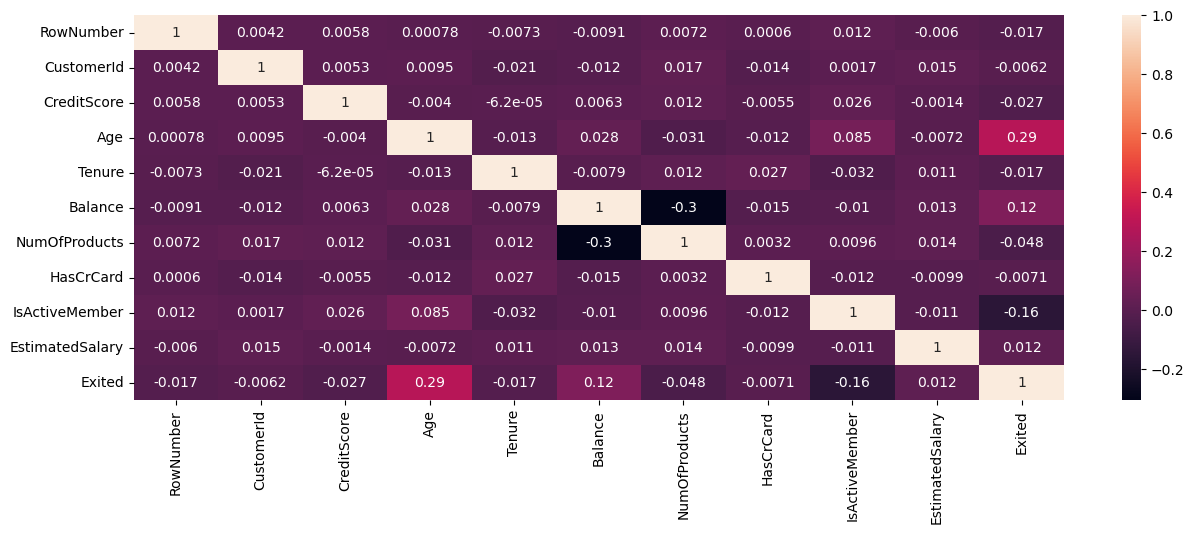

In [8]:
#проверим, есть подозрение на мультиколлинеарность между некторыми признаками
correlation = df.corr()
plt.figure(figsize = (15,5))
sns.heatmap(correlation, annot = True)

Критично высоких связей между признаками не наблюдается, поэтому можно оставить модель с изначальным набором признаков.

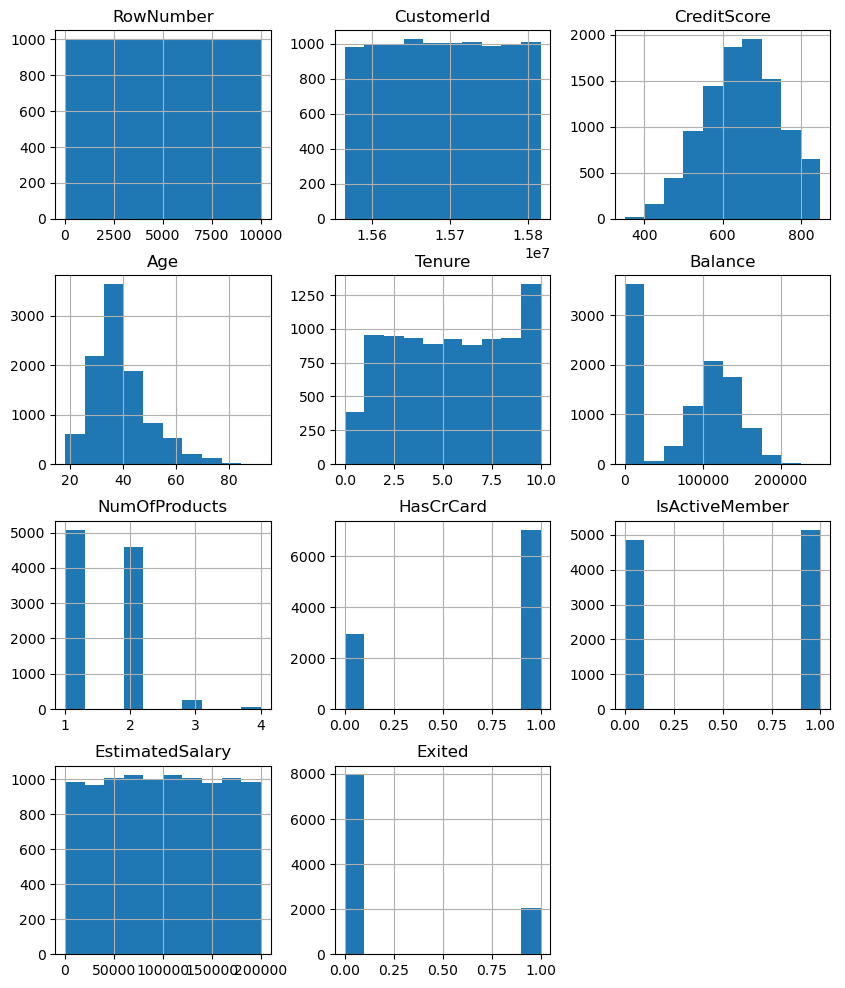

In [9]:
# построим общую диаграмму для всех столбцов таблицы,
# чтобы визуально оценить нормальность распределений
df.hist(figsize=(10, 12))
None

Визуальная оценка позволяет сделать вывод о том, что ни один из признаков не распределен нормально.

In [10]:
# проверим датасет на наличие пропусков в данных
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В столбце **Tenure** наблюдается 909 прорусков.\
Будем считать, что если это пропуск, значит человек не является клиентом банка. Заполним пропуски нулями.

In [11]:
df.Tenure = df.Tenure.fillna(0)

In [12]:
# проверим все ли сработало корректно
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Подготовка данных

На основании имеющихсф данных о клиентах нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Соответственно:
- **Exited** - это целевой признак
- все остальные столбцы - это признаки, которые влияют на результат классификации

Посмотрев на основную информацию о признаках, можно сказать, что One-Hot Encoding и масштабирование нужно применить точечно.

Дополнительно проверим уникальные значения для категориальных признаков, чтобы убедиться в том, что OHE к ним применять имеет смысл.

In [13]:
df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [14]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

OHE применим к столбцам **Gender** и **Geography**, масштабирование - к **CreditScore**, **Balance** и **EstimatedSalary**, так как мы не хотим, чтобы при обучении какой-то признак с более высоким значением был засчитан как более значимый.

In [15]:
# применяем ohe к 2 признакам
df = pd.get_dummies(df, drop_first=True, columns=['Gender', 'Geography'])

In [16]:
# приверим, что получилось
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Дальше разделим датасет на 3 выборки - обучающую, валидационную и тестовую.\
Кроме того, удалим признаки Surmane и CustomerId, так как они никак не влияют на качество обучения (а если и влияют, то только в негативном ключе).

In [17]:
target = df['Exited']
features = df.drop(['Exited', 'Surname', 'CustomerId', 'RowNumber'], axis=1)

# разделяем на обучающую и тестовую выборки (80/20)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=12345)

# разделяем обучающую выборку на обучающую и валидационную (75/25)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [18]:
# признаки, которые будем масштабировать
cols_to_scale = ['CreditScore', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(df[cols_to_scale])

df[cols_to_scale] = scaler.transform(df[cols_to_scale])

#pd.options.mode.chained_assignment = None

In [19]:
# приверим, что получилось
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,-0.326221,42,2.0,-1.225848,1,1,1,0.021886,1,0,0,0
1,2,15647311,Hill,-0.440036,41,1.0,0.117350,1,0,1,0.216534,0,0,0,1
2,3,15619304,Onio,-1.536794,42,8.0,1.333053,3,1,0,0.240687,1,0,0,0
3,4,15701354,Boni,0.501521,39,1.0,-1.225848,2,0,0,-0.108918,0,0,0,0
4,5,15737888,Mitchell,2.063884,43,2.0,0.785728,1,1,1,-0.365276,0,0,0,1


Проверим, сколько данных в получившихся выборках и сколько это число составляет в % от изначального датасета.

In [20]:
target_train.shape

(6000,)

In [21]:
round(len(target_train) / len(df), 3)

0.6

In [22]:
target_test.shape

(2000,)

In [23]:
round(len(target_test) / len(df), 3)

0.2

In [24]:
target_valid.shape

(2000,)

In [25]:
round(len(target_valid) / len(df), 3)

0.2

Судя по полученным цифрам, данные разделены на 3 выборки в верном соотношении.

## Проверка на наличие дисбаланса

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

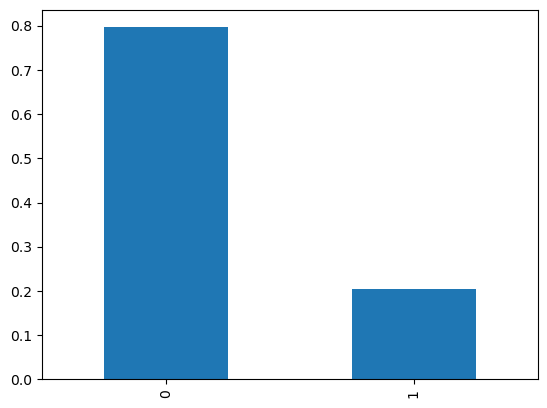

In [26]:
class_frequency = df['Exited'].value_counts(normalize=1)
print(class_frequency)
class_frequency.plot(kind='bar')

Из полученных данных видно, что в целевом признаке наблюдается достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента.

Кроме того, сравним качество предсказаний с константной моделью. За константу примем пример 0, так как это значение встречается почти в 80% случаев.

In [27]:
target_pred_constant = pd.Series([0]*len(target))
print(accuracy_score(target, target_pred_constant))

0.7963


## Проверка моделей без учета дисбаланса

Теперь обучим несколько моделей без учета дисбаланса, и посмотрим на ключевые метрики - Recall, Precision и F1-score.\
Перед этим подберем оптимальные гиперпараметры для моделей на основании метрики F1-score.\
Конечно, можно было бы использовать accuracy как milestone, но для этого проекта выберем компромиссный вариант между precision и recall.


**Дерево решений**

In [28]:
# дерево решений - подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

start_time = time.time()
print('Время выполнения кода = ', (time.time() - start_time), 'сек.')

Оптимальная глубина дерева = 7
Качество модели -  0.5321375186846039
Время выполнения кода =  0.0 сек.


In [29]:
# обучаем модель с оптимальными значениями гиперпараметров
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [30]:
print("Accuracy_tree:", accuracy_score(target_valid, predictions_valid_tree))
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

Accuracy_tree: 0.857
Recall_tree: 0.44501278772378516
Precision_tree: 0.7160493827160493
F1_tree: 0.5488958990536277


 
**Случайный лес**

In [31]:
# случайный лес - подберем лучшие гиперпараметры
best_model = None
for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=100, 
                                              max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_depth = depth

print('Оптимальная глубина дерева =', best_depth)
print('Качество модели - ', f1_forest)

start_time = time.time()
print('Время выполнения кода = ', (time.time() - start_time), 'сек.')

Оптимальная глубина дерева = 7
Качество модели -  0.5439469320066335
Время выполнения кода =  0.0 сек.


In [32]:
# обучаем модель с оптимальными значениями гиперпараметров

model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [33]:
print("Accuracy_forest:", accuracy_score(target_valid, predictions_valid_forest))
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

Accuracy_forest: 0.8625
Recall_forest: 0.4194373401534527
Precision_forest: 0.7735849056603774
F1_forest: 0.5439469320066335


 
 **Логистическая регрессия**

In [34]:
# логистическая регрессия - подберем лучшие гиперпараметры
model_log = LogisticRegression(random_state=12345)
# обучаем модель на тренировочной выборке
model_log.fit(features_train, target_train)
# получаем предсказания на валидационной выборке
predictions_valid_log = model_log.predict(features_valid)

start_time = time.time()
print('Время выполнения кода = ', (time.time() - start_time), 'сек.')

Время выполнения кода =  0.0 сек.


In [35]:
print("Accuracy_log:", accuracy_score(target_valid, predictions_valid_log))
print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

Accuracy_log: 0.799
Recall_log: 0.056265984654731455
Precision_log: 0.4
F1_log: 0.09865470852017938


Оценим модели по качеству - F1-score.

**Дерево решений**

Качество модели = 0.56

**Случайный лес**

Качество модели = 0.56

**Логистическая регрессия**

Качество модели =  0.31


Таким образом, обучив модели без учета дисбаланса классов, наилучшее значение метрики F1-score демонстрирует модель Дерево решений, в то время как наибольшее значение метрики accuracy наблюдается у модели Random Forest.

Далее, посмотрим на то, как выглядит дисбаланс классов для 3 обученных моделей.

C:\Users\MamaevaPolina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


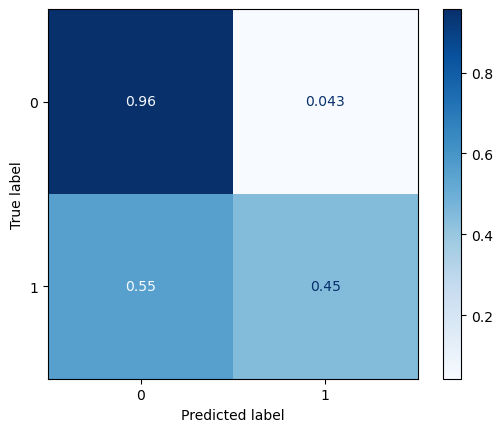

In [36]:
# построим матрицу ошибок, чтобы посмотреть на соотношения TP, TN, FP и FN
plot_confusion_matrix(estimator=model_tree, X=features_valid, y_true=target_valid,
                      normalize='true', cmap='Blues')
None

C:\Users\MamaevaPolina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


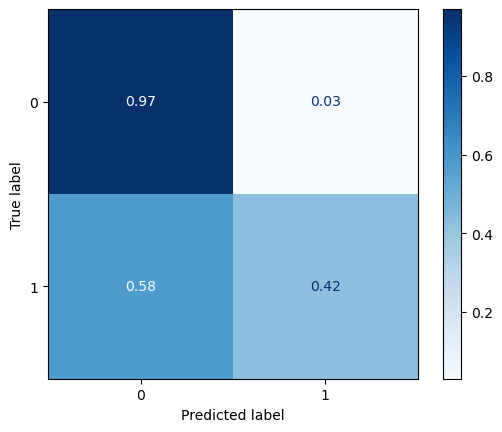

In [37]:
# построим матрицу ошибок, чтобы посмотреть на соотношения TP, TN, FP и FN 
plot_confusion_matrix(estimator=model_forest, X=features_valid, y_true=target_valid,
                      normalize='true', cmap='Blues')
None

C:\Users\MamaevaPolina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


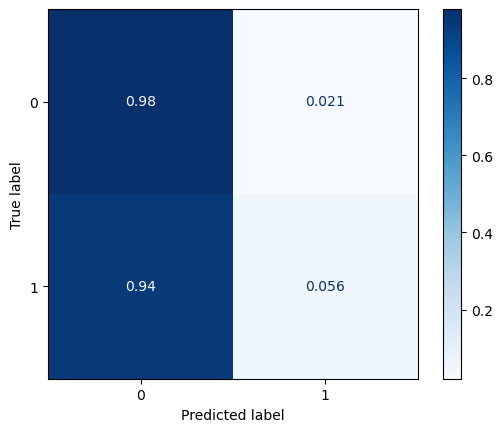

In [38]:
# построим матрицу ошибок, чтобы посмотреть на соотношения TP, TN, FP и FN 
plot_confusion_matrix(estimator=model_log, X=features_valid, y_true=target_valid,
                      normalize='true', cmap='Blues')
None

Матрицы ошибок наглядно демонстрируют то, что несмотря на то, что значение accuracy достаточно высокое, для всех трех моделей наблюдается остаточно сильный дисбаланс классов.\
К примеру, для моделей Дерево решений и Случайный лес ситуация схожая - факт того, что клиент не ушел (0), модели определяют правильно примерно в 95% случаев, в то время как результат предсказаний по факту ухода (1) в среднем всего 45%.

## Борьба с дисбалансом

Рассмотрим 2 метода борьбы с дисбалансом классов:
1. Увеличение выборки (upsampling)
2. Уменьшение выборки (downsampling)

**1. Уменьшение выборки**

In [39]:
# уменьшим выборку в 4 раза, так как положительный класс больше отрицательного в 4 раза
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # fractioning samples
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                   [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2414, 11)
(2414,)


**Дерево решений**

In [40]:
# дерево решений - подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 7
Качество модели -  0.5014031805425632


In [41]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7)
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid_tree = model_tree.predict(features_valid)

print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_tree: 0.7519181585677749
Precision_tree: 0.4298245614035088
F1_tree: 0.5469767441860465
ROC-AUC_tree: 0.8160244723176378


**Случайный лес**

In [42]:
# случайный лес - подберем лучшие гиперпараметры
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [43]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=10, 
                                      max_depth=9)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)

print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.7289002557544757
Precision_forest: 0.45893719806763283
F1_forest: 0.5632411067193676
ROC-AUC_forest: 0.8369974519923893


**Логистическая регрессия**

In [44]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')

model_log.fit(features_downsampled, target_downsampled)
predictions_valid_log = model_log.predict(features_valid)

print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.7084398976982097
Precision_log: 0.3169336384439359
F1_log: 0.4379446640316205
ROC-AUC_log: 0.7180406250645744


Вывод: уменьшение выборки не помогло увеличить качество модели, попробуем использовать обратный метод.

**2. Увеличение выборки**

In [45]:
# увеличим выборку в 4 раза, так как отрицательный класс больше положительного в 4 раза
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # сцепляем выборки
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешиваем значения, чтобы они не шли друг за другом 
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9657, 11)
(9657,)


**Дерево решений**

In [46]:
# дерево решений - подберем лучшие гиперпараметры
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 6
Качество модели -  0.5060483870967742


In [47]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7)
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid_tree = model_tree.predict(features_valid)

print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_tree: 0.6956521739130435
Precision_tree: 0.45714285714285713
F1_tree: 0.5517241379310345
ROC-AUC_tree: 0.7980111870727161


**Случайный лес**

In [48]:
# случайный лес - подберем лучшие гиперпараметры
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [49]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=10, 
                                      max_depth=9)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)

print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.6649616368286445
Precision_forest: 0.4914933837429111
F1_forest: 0.5652173913043478
ROC-AUC_forest: 0.8427268926864393


**Логистическая регрессия**

In [50]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_log.fit(features_upsampled, target_upsampled)
predictions_valid_log = model_log.predict(features_valid)

print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.7007672634271099
Precision_log: 0.3145809414466131
F1_log: 0.43423137876386686
ROC-AUC_log: 0.7170328665959859


In [52]:
# для удобства соберем все полученные значения метрики F1-score в один датафрейм

model_name = ['Tree', 'Forest', 'Log']
initial_values = [0.55, 0.55, 0.10]
down_values = [0.55, 0.56, 0.44]
up_values = [0.55, 0.57, 0.43]

df_metrics = pd.DataFrame({'Model Name': model_name,
                           'Initial': initial_values,
                           'Downsampling': down_values,
                           'Upsampling': up_values })

df_metrics

,Model Name,Initial,Downsampling,Upsampling
0,Tree,0.55,0.55,0.55
1,Forest,0.55,0.56,0.57
2,Log,0.10,0.44,0.43


**Вывод:**
- Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score.
- Наибольшее значение метрики F1-score получено на модели **Случайный лес** при помощи взвешивания классов. Поэтому для тестирования будем использовать эту модель.
- Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.